# Telescope Array Weather Determination

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The Telescope Array is a high energy physics experiment designed to observe air showers induced by ultra high energy cosmic rays.  It does this using a combination of ground array and air-fluorescence techniques. The array of scintillator surface detectors samples the footprint of the air shower when it reaches the Earth's surface, while the fluorescence telescopes measure the scintillation light generated as the shower passes through the gas of the atmosphere. The ultimate goal of the experiment is to determine the sources of ultra high energy cosmic rays to provide a better understanding of the nature of the universe.

The fluorescent telescopes operate on dark moonless nights. However the data they collect is only usable if the night sky was clear (not cloudy). The goal of our machine learning project is to construct a model that can determine whether the sky was clear from the data taken by the telescopes.



### The Black Rock telescope array site.

The Black Rock detector consists of 12 mirrors (2 rows of 6), each mirror contains 256 photo-multiplier tubes (pmts). The night's observation is divided into parts of varying time length (often 20-30 minutes). The data has one set of entries per minute. The average gives the pmt signal in 1.6 microsecond averaged over a minute, rms is the standard deviation of the light signal over this minute. The flag is: 1 for usable data, 0 for not usable.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn

import tensorflow as tf
PATH = '/content/drive/MyDrive/TA_weather/'

Here is an example of a file containing data for August 20, 2009. The night time was divided into parts of 20-30 minutes each during some of which the data was taken.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/TA_weather/y2009m08d20.ped.csv')
df.head()

,part,minute,mirror,pmt,average,rms,flag
0,5,0,0,0,5103,739,1
1,5,0,0,1,6091,714,1
2,5,0,0,2,5857,876,1
3,5,0,0,3,5126,1049,1
4,5,0,0,4,4307,785,1


In [4]:
df.dtypes

part       int64
minute     int64
mirror     int64
pmt        int64
average    int64
rms        int64
flag       int64
dtype: object

In [5]:
df.shape

(1253376, 7)

What parts are present in this night's data?

(array([     0.,      0.,      0.,      0.,      0.,  70656., 116736.,
             0.,      0.,      0.,  70656., 116736.,      0.,      0.,
             0.,  67584., 141312.,      0.,      0.,      0.,  76800.,
        141312.,      0.,      0.,      0.,  82944., 119808.,      0.,
             0.,      0.,  86016., 110592.,      0.,      0.,      0.,
         52224.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <BarContainer object of 50 artists>)

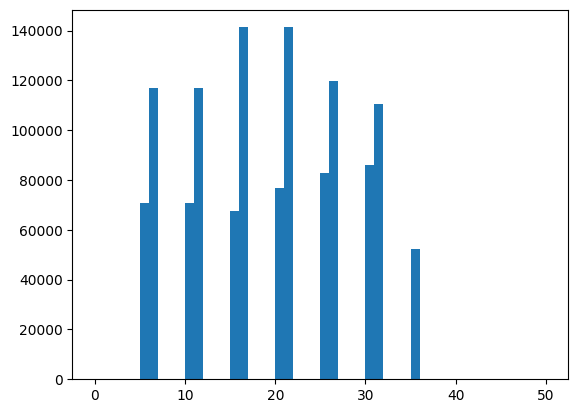

In [6]:
plt.hist(df['part'], bins=50, range=(0,50))

In [7]:
set(df['part'])

{5, 6, 10, 11, 15, 16, 20, 21, 25, 26, 30, 31, 35}

Pick one tube (say mirror = 1, pmt = 3), plot the average vs time for this tube.

In [8]:
one_tube_df = df[(df['mirror'] == 1) & (df['pmt'] == 3)]
one_tube_df

,part,minute,mirror,pmt,average,rms,flag
259,5,0,1,3,5672,703,1
3331,5,1,1,3,5672,697,1
6403,5,2,1,3,5671,692,1
9475,5,3,1,3,5672,686,1
12547,5,4,1,3,5672,677,1
...,...,...,...,...,...,...,...
1238275,35,12,1,3,5637,743,1
1241347,35,13,1,3,5641,743,1
1244419,35,14,1,3,5644,747,1
1247491,35,15,1,3,5645,749,1


In [9]:
len(one_tube_df)

408

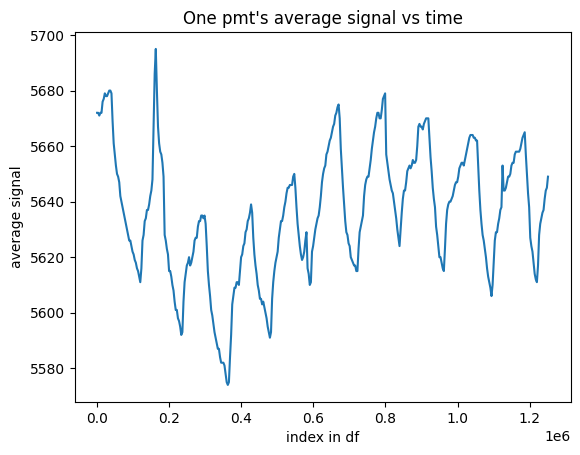

In [10]:
plt.plot(one_tube_df['average'])
plt.title("One pmt's average signal vs time")
plt.xlabel('index in df')
plt.ylabel('average signal');

Pick one minute a night (say part = 5, minute = 3). Plot the average of all tubes at this minute.

In [11]:
one_minute_df = df[(df['part'] == 5) & (df['minute'] == 3)]
len(one_minute_df)

3072

We know the direction in which each tube is pointing given by the azimuth angle and the elevation. We will use azimuth and elevation as coordinates for ploting the tubes average.

In [12]:
br_pointing_df = pd.read_csv('/content/drive/MyDrive/TA_weather/br_pointing.csv', header=None,
                             names = ['mirror', 'pmt', 'elevation', 'azimuth'])
br_pointing_df.head()

,mirror,pmt,elevation,azimuth
0,0,0,18.11,-153.29
1,0,1,19.07,-153.80
2,0,2,19.98,-153.16
3,0,3,20.95,-153.69
4,0,4,21.85,-153.03


In [13]:
azimuth = br_pointing_df['azimuth'].values
elevation = br_pointing_df['elevation'].values
azimuth[ azimuth < 0] += 360


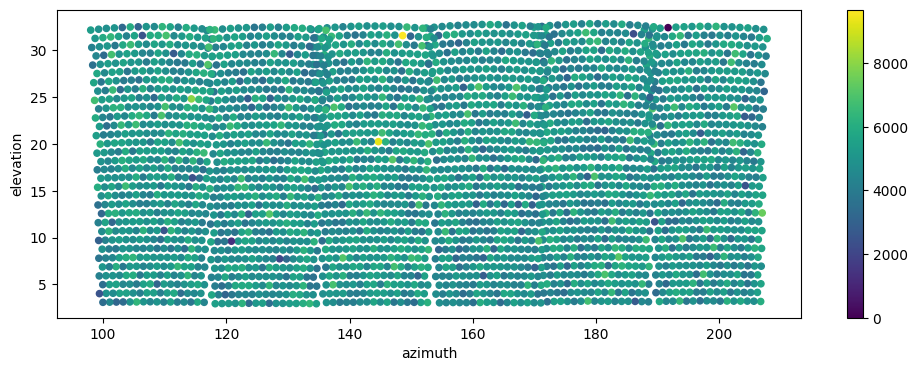

In [14]:
plt.figure(figsize=(12,4))
plt.scatter(azimuth, elevation, c=one_minute_df.average, s=20)
plt.colorbar()
plt.xlabel('azimuth')
plt.ylabel('elevation')
plt.savefig('minute_avg.pdf')

Our first goal is to construct a machine learning model that will classify the weather as clear or cloudy given one minute snapshots as above. However tubes frequently have bias in their measurements, to account for that it is better to consider the differences of snapshots taken in two consecutive minutes.

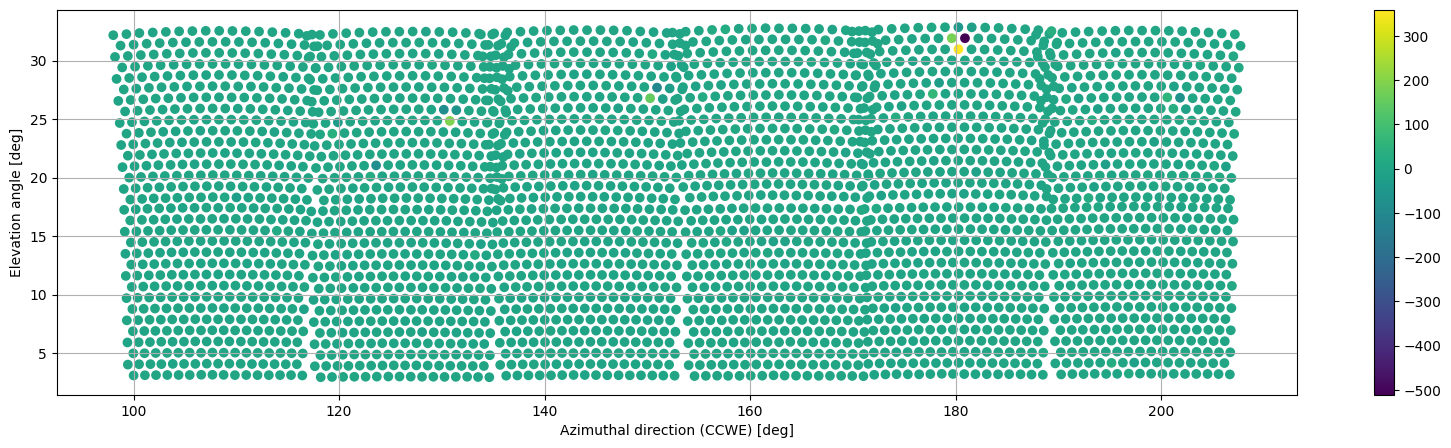

In [15]:
z1 = df.loc[(df.part==5)&(df.minute==1)].average
z2 = df.loc[(df.part==5)&(df.minute==2)].average
dz12 = np.array(z2)-np.array(z1)
x = br_pointing_df.azimuth
y = br_pointing_df.elevation
plt.figure(figsize=(20,5))
plt.scatter(x,y,c=dz12,cmap='viridis')
plt.colorbar()
plt.xlabel('Azimuthal direction (CCWE) [deg]')
plt.ylabel('Elevation angle [deg]')
plt.grid()

In [16]:
dz12.argmax()

637

In [17]:
df.loc[(df.part==5)&(df.minute==1)]

,part,minute,mirror,pmt,average,rms,flag
3072,5,1,0,0,5103,726,1
3073,5,1,0,1,6092,706,1
3074,5,1,0,2,5862,877,1
3075,5,1,0,3,5141,1039,1
3076,5,1,0,4,4297,745,1
...,...,...,...,...,...,...,...
6139,5,1,11,251,3584,1007,1
6140,5,1,11,252,4848,886,1
6141,5,1,11,253,6011,884,1
6142,5,1,11,254,5255,994,1


In [18]:
df.loc[(df.part==5)&(df.minute==1)].values[637]

array([   5,    1,    2,  125, 5624,  850,    1])

In [19]:
df.loc[(df.part==5)&(df.minute==2)].values[637]

array([   5,    2,    2,  125, 5983, 1644,    1])

We see that the tube 125 registered the maximal change in average between 1st and 2nd minutes of part 5.

Plot the average registered by this tube vs time overnight.

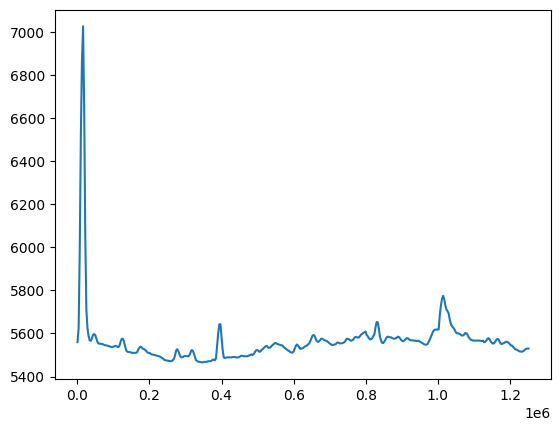

In [20]:
plt.plot(df.loc[(df.mirror==2)&(df.pmt==125)].average);

Append the azimuth and elevation of a pms to the main dataframe.

In [21]:
br_pointing_df.head()

,mirror,pmt,elevation,azimuth
0,0,0,18.11,206.71
1,0,1,19.07,206.20
2,0,2,19.98,206.84
3,0,3,20.95,206.31
4,0,4,21.85,206.97


In [22]:
br_pointing_df.iloc[4*256+37]

mirror         4.00
pmt           37.00
elevation     23.12
azimuth      168.77
Name: 1061, dtype: float64

In [23]:
def mirpmt2idx( mir, pmt):
  return mir * 256 + pmt

In [24]:
mirpmt2idx(4, 37)

1061

In [25]:
br_pointing_df.iloc[mirpmt2idx(df.mirror, df.pmt)].elevation

0       18.11
1       19.07
2       19.98
3       20.95
4       21.85
        ...  
3067    13.49
3068    14.46
3069    15.38
3070    16.34
3071    17.25
Name: elevation, Length: 1253376, dtype: float64

In [26]:
azimuth = np.array(br_pointing_df.iloc[mirpmt2idx(df.mirror, df.pmt)].azimuth)
elevation = np.array(br_pointing_df.iloc[mirpmt2idx(df.mirror, df.pmt)].elevation)
df['azimuth'] = azimuth
df['elevation'] = elevation

In [27]:
df.head()

,part,minute,mirror,pmt,average,rms,flag,azimuth,elevation
0,5,0,0,0,5103,739,1,206.71,18.11
1,5,0,0,1,6091,714,1,206.20,19.07
2,5,0,0,2,5857,876,1,206.84,19.98
3,5,0,0,3,5126,1049,1,206.31,20.95
4,5,0,0,4,4307,785,1,206.97,21.85


In [28]:
df_5 = df[df.part==5]
df_5_2 = df[(df.part==5)&(df.minute==2)]

Sliding plot of the average signal of all pmts during each minute of part 5 of the night.

In [29]:
#px.scatter(df_5,x="azimuth",y="elevation",color="average",animation_frame="minute",range_color=(3000,7000))



We next want to look at plots of minute differences of averages - one taken in a part on a clear night and one on a cloudy night.

Create a dataframe of differences of averages for part 6.

In [30]:
df_6 = df[df.part==6]
df_6.head()

,part,minute,mirror,pmt,average,rms,flag,azimuth,elevation
70656,6,0,0,0,5031,696,1,206.71,18.11
70657,6,0,0,1,6025,688,1,206.20,19.07
70658,6,0,0,2,5798,789,1,206.84,19.98
70659,6,0,0,3,4973,863,1,206.31,20.95
70660,6,0,0,4,4230,694,1,206.97,21.85


In [31]:
df_6_val = df_6.values
df_6_val[:10]

array([[6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0310e+03,
        6.9600e+02, 1.0000e+00, 2.0671e+02, 1.8110e+01],
       [6.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 6.0250e+03,
        6.8800e+02, 1.0000e+00, 2.0620e+02, 1.9070e+01],
       [6.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 5.7980e+03,
        7.8900e+02, 1.0000e+00, 2.0684e+02, 1.9980e+01],
       [6.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 4.9730e+03,
        8.6300e+02, 1.0000e+00, 2.0631e+02, 2.0950e+01],
       [6.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 4.2300e+03,
        6.9400e+02, 1.0000e+00, 2.0697e+02, 2.1850e+01],
       [6.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00, 4.4280e+03,
        7.1900e+02, 1.0000e+00, 2.0646e+02, 2.2830e+01],
       [6.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00, 4.0320e+03,
        8.6700e+02, 1.0000e+00, 2.0711e+02, 2.3740e+01],
       [6.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e+00, 4.9400e+03,
        8.2000e+02, 1.0000e+00, 2.0659e+02, 2.4720e+01],


In [32]:
df_6_diff = df_6_val[12*256:]-df_6_val[:-12*256]
df_6_diff[:10]

array([[ 0.,  1.,  0.,  0.,  4., 22.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -1.,  2.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -2., -2.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -2., -3.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -4.,  4.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -3.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -2., -5.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -5., -5.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -4., -1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -2., -6.,  0.,  0.,  0.]])

In [33]:
df_6_diff[:,0] = df_6_val[:-12*256,0]
df_6_diff[:,1] = (df_6_val[12*256:,1]+df_6_val[:-12*256,1])/2
df_6_diff[:,2:3] = df_6_val[:-12*256,2:3]
df_6_diff[:,6:] = df_6_val[:-12*256,6:]
df_6_diff[-20:]

array([[  6.  ,  36.5 ,  11.  ,   0.  ,   0.  ,   2.  ,   1.  , 100.85,
         14.49],
       [  6.  ,  36.5 ,  11.  ,   0.  ,   0.  ,   4.  ,   1.  , 100.27,
         15.41],
       [  6.  ,  36.5 ,  11.  ,   0.  ,   1.  ,   1.  ,   1.  , 100.81,
         16.39],
       [  6.  ,  36.5 ,  11.  ,   0.  ,   1.  ,  -9.  ,   1.  , 100.21,
         17.29],
       [  6.  ,  36.5 ,  11.  ,   0.  ,   1.  ,   9.  ,   1.  , 100.  ,
          3.09],
       [  6.  ,  36.5 ,  11.  ,   0.  ,   0.  ,  -1.  ,   1.  ,  99.44,
          4.02],
       [  6.  ,  36.5 ,  11.  ,   0.  ,   0.  ,   0.  ,   1.  ,  99.97,
          4.98],
       [  6.  ,  36.5 ,  11.  ,   0.  ,  -1.  ,  -6.  ,   1.  ,  99.4 ,
          5.91],
       [  6.  ,  36.5 ,  11.  ,   0.  ,  -1.  ,   1.  ,   1.  ,  99.93,
          6.87],
       [  6.  ,  36.5 ,  11.  ,   0.  ,   0.  ,   3.  ,   1.  ,  99.34,
          7.8 ],
       [  6.  ,  36.5 ,  11.  ,   0.  ,  -1.  ,   2.  ,   1.  ,  99.88,
          8.77],
       [  6.  ,  36.5

In [34]:
df_6_diff_df = pd.DataFrame(df_6_diff,columns=['part','min','mir','pmt','dave','drms','flag','azimuth','elevation'])
df_6_diff_df.head()

,part,min,mir,pmt,dave,drms,flag,azimuth,elevation
0,6.0,0.5,0.0,0.0,4.0,22.0,1.0,206.71,18.11
1,6.0,0.5,0.0,0.0,-1.0,2.0,1.0,206.20,19.07
2,6.0,0.5,0.0,0.0,-2.0,-2.0,1.0,206.84,19.98
3,6.0,0.5,0.0,0.0,-2.0,-3.0,1.0,206.31,20.95
4,6.0,0.5,0.0,0.0,-4.0,4.0,1.0,206.97,21.85


In [35]:
#px.scatter(df_6_diff_df,x="azimuth",y="elevation",color="dave",animation_frame="min",range_color=(-100,100),
#          color_continuous_scale=px.colors.cyclical.IceFire)

We repeat the above process to plot the differences of averages for data taken on a cloudy night.

In [36]:
df2 = pd.read_csv('/content/drive/MyDrive/TA_weather/y2009m08d22.ped.csv')
df2.head()

,part,minute,mirror,pmt,average,rms,flag
0,5,0,0,0,4882,332,1
1,5,0,0,1,5861,383,1
2,5,0,0,2,5624,302,1
3,5,0,0,3,4762,476,1
4,5,0,0,4,4028,360,1


In [37]:
azimuth = np.array(br_pointing_df.iloc[256*df2.mirror+df2.pmt].azimuth)
elevation = np.array(br_pointing_df.iloc[256*df2.mirror+df2.pmt].elevation)
df2['azimuth'] = azimuth
df2['elevation'] = elevation

In [38]:
df2_6 = df2[df2.part==6]

In [39]:
df2_6_val = df2_6.values
df2_6_diff = df2_6_val[12*256:]-df2_6_val[:-12*256]
df2_6_diff[:,0] = df2_6_val[:-12*256,0]
df2_6_diff[:,1] = (df2_6_val[12*256:,1]+df2_6_val[:-12*256,1])/2
df2_6_diff[:,2:3] = df2_6_val[:-12*256,2:3]
df2_6_diff[:,6:] = df2_6_val[:-12*256,6:]

In [40]:
df2_6_diff_df = pd.DataFrame(df2_6_diff,columns=['part','min','mir','pmt','dave','drms','flag','azimuth','elevation'])

In [41]:
# px.scatter(df2_6_diff_df,x="azimuth",y="elevation",color="dave",
#            animation_frame="min",range_color=(-50,50),
#            color_continuous_scale=px.colors.cyclical.IceFire)